## 1. 모듈 임포트

In [2]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/dilab162/anaconda3/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## 2. 데이터 로드

In [3]:
def load_data(path, client_num):
    path_list = [path+'/chunked_siRNA_{i}_{client_num}.npy'.format(i=i, client_num=client_num) for i in ['train_X', 'train_y', 'test_X', 'test_y']]
    train_X, train_y, test_X, test_y = np.load(path_list[0], allow_pickle=True), np.load(path_list[1], allow_pickle=True), np.load(path_list[2], allow_pickle=True), np.load(path_list[3], allow_pickle=True)
    train = dc.data.DiskDataset.from_numpy(train_X, train_y)
    test = dc.data.DiskDataset.from_numpy(test_X, test_y)
    return train, test

In [4]:
# 클라이언트 고유번호 입력
client_num = 1
train, test = load_data('./TFbinding_chunked_data/', client_num)

In [5]:
len(train), len(test)

(46036, 11510)

### A,G,T,C 의 구성으로 101개 배열

In [6]:
train

<DiskDataset X.shape: (46036, 101, 4), y.shape: (46036, 1), w.shape: (46036, 1), task_names: [0]>

## 3. 모델 정의 및 학습

In [83]:
# 중앙집중식 학습

features = tf.keras.Input(shape=(101, 4))
prev = features
for i in range(3):
    prev = layers.Conv1D(filters=15, kernel_size=10, activation=tf.nn.relu, padding='same')(prev)
    prev = layers.Dropout(rate=0.5)(prev)
logits = layers.Dense(units=1)(layers.Flatten()(prev))
output = layers.Activation(tf.math.sigmoid)(logits)
keras_model = tf.keras.Model(inputs=features, outputs=[output, logits])
model = dc.models.KerasModel(
    keras_model,
    loss=dc.models.losses.SigmoidCrossEntropy(),
    output_types=['prediction', 'loss'],
    batch_size=1000,
    model_dir='tf')

In [84]:
model.model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 101, 4)]          0         
                                                                 
 conv1d_33 (Conv1D)          (None, 101, 15)           615       
                                                                 
 dropout_33 (Dropout)        (None, 101, 15)           0         
                                                                 
 conv1d_34 (Conv1D)          (None, 101, 15)           2265      
                                                                 
 dropout_34 (Dropout)        (None, 101, 15)           0         
                                                                 
 conv1d_35 (Conv1D)          (None, 101, 15)           2265      
                                                                 
 dropout_35 (Dropout)        (None, 101, 15)           0  

In [88]:
# Train the model, tracking its performance on the training and validation datasets.
train_roc_list = []
test_roc_list = []
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
for i in range(50):
    model.fit(train, nb_epoch=1)
    train_roc = model.evaluate(train, [metric])
    test_roc = model.evaluate(test, [metric])
    print('Epoch %d:' % (i), end=' ')
    print(train_roc, test_roc)
    train_roc_list.append(train_roc['roc_auc_score'])
    test_roc_list.append(test_roc['roc_auc_score'])

Epoch 0: {'roc_auc_score': 0.8602395431154204} {'roc_auc_score': 0.586955810504275}
Epoch 1: {'roc_auc_score': 0.8577640964920892} {'roc_auc_score': 0.5877669145873321}
Epoch 2: {'roc_auc_score': 0.875730739028008} {'roc_auc_score': 0.5681559173791659}
Epoch 3: {'roc_auc_score': 0.8455889186243929} {'roc_auc_score': 0.5876801241784447}
Epoch 4: {'roc_auc_score': 0.8713267071481546} {'roc_auc_score': 0.5815452691502355}
Epoch 5: {'roc_auc_score': 0.8809020639287584} {'roc_auc_score': 0.5779550543825975}
Epoch 6: {'roc_auc_score': 0.8822684788812785} {'roc_auc_score': 0.5833601429360786}
Epoch 7: {'roc_auc_score': 0.886200972773609} {'roc_auc_score': 0.5771025998953063}
Epoch 8: {'roc_auc_score': 0.8906838783428583} {'roc_auc_score': 0.575235470104112}
Epoch 9: {'roc_auc_score': 0.8858767868568769} {'roc_auc_score': 0.5782545040132612}
Epoch 10: {'roc_auc_score': 0.8829855847184656} {'roc_auc_score': 0.5831156757110452}
Epoch 11: {'roc_auc_score': 0.8932579099773144} {'roc_auc_score': 0.

## 4. 모델 검증

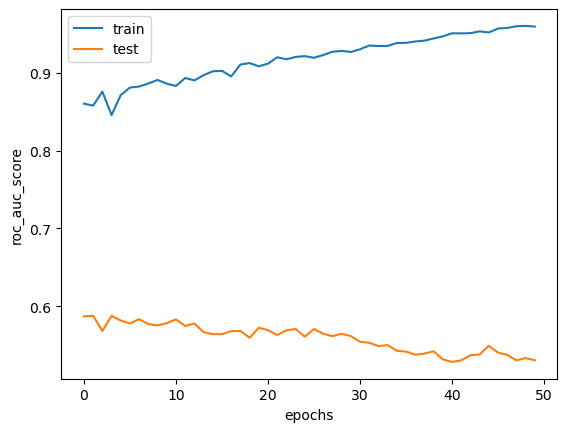

In [89]:
from matplotlib import pyplot as plt

x_values = [i for i in range(len(train_roc_list))]
y_values_1 = train_roc_list
y_values_2 = test_roc_list

plt.plot(x_values, y_values_1)
plt.plot(x_values, y_values_2)

plt.legend(['train', 'test'])

plt.xlabel('epochs')
plt.ylabel('roc_auc_score')

plt.show()

## 5. 연합학습 모델 생성

In [7]:
# 연합학습 모델 생성
features = tf.keras.Input(shape=(101, 4))
prev = features
for i in range(3):
    prev = layers.Conv1D(filters=15, kernel_size=10, activation=tf.nn.relu, padding='same')(prev)
    prev = layers.Dropout(rate=0.5)(prev)
logits = layers.Dense(units=1)(layers.Flatten()(prev))
output = layers.Activation(tf.math.sigmoid)(logits)
keras_model = tf.keras.Model(inputs=features, outputs=[output, logits])
model_fl = dc.models.KerasModel(
    keras_model,
    loss=dc.models.losses.SigmoidCrossEntropy(),
    output_types=['prediction', 'loss'],
    batch_size=1000,
    model_dir='tf')



# 학습 및 검증 함수 정의
train_roc_list_fl = []
test_roc_list_fl = []
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
def fit_model(model, eopch):
    for i in range(eopch):
        loss = model.fit(train, nb_epoch=1)
        train_roc = model.evaluate(train, [metric])
        print('Epoch %d:' % (i))
        print(train_roc)
        return train_roc['roc_auc_score']
        
def eval_model(model):
    test_roc = model.evaluate(test, [metric])
    print(test_roc)
    return test_roc['roc_auc_score']

2023-05-05 21:23:50.050727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 21:23:52.839692: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10019 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1
2023-05-05 21:23:52.840308: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10086 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


## 6. 연합학습 객체 생성 및 학습

In [12]:
import flwr as fl

class TFbinding_model(fl.client.NumPyClient):
    def get_parameters(self, config):
        return model_fl.model.get_weights()

    def fit(self, parameters, config):
        model_fl.model.set_weights(parameters)
        train_result = fit_model(model_fl, 1)
        train_roc_list_fl.append(train_result)
        return self.get_parameters(config), len(train), {}

    def evaluate(self, parameters, config):
        model_fl.model.set_weights(parameters)
        eval_result = eval_model(model_fl)
        test_roc_list_fl.append(eval_result)
        return 0.1, len(test), {"accuracy": float(eval_result)}

server_ip = '210.115.49.162'
fl.client.start_numpy_client(server_address=server_ip + ":8080", client=TFbinding_model())

INFO flower 2023-05-05 21:25:10,834 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2023-05-05 21:25:10,837 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2023-05-05 21:25:10,840 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2023-05-05 21:25:10,842 | connection.py:39 | ChannelConnectivity.READY


Epoch 0:
{'roc_auc_score': 0.5369268890603642}
{'roc_auc_score': 0.4662026333391497}
Epoch 0:
{'roc_auc_score': 0.5464005649594276}
{'roc_auc_score': 0.4671282462339324}
Epoch 0:
{'roc_auc_score': 0.5521408199546287}
{'roc_auc_score': 0.4718903587215727}
Epoch 0:
{'roc_auc_score': 0.5563576226805398}
{'roc_auc_score': 0.4799082475426045}
Epoch 0:
{'roc_auc_score': 0.5662707417637349}
{'roc_auc_score': 0.4820357485604606}
Epoch 0:
{'roc_auc_score': 0.5741763734985312}
{'roc_auc_score': 0.47911486506136225}
Epoch 0:
{'roc_auc_score': 0.5877041059080795}
{'roc_auc_score': 0.4730172708369685}
Epoch 0:
{'roc_auc_score': 0.6012504419426024}
{'roc_auc_score': 0.463562569068807}
Epoch 0:
{'roc_auc_score': 0.6157791345832242}
{'roc_auc_score': 0.47166952029895887}
Epoch 0:
{'roc_auc_score': 0.616212102001716}
{'roc_auc_score': 0.4745136101901937}
Epoch 0:
{'roc_auc_score': 0.6194404983931012}
{'roc_auc_score': 0.4751756710579887}
Epoch 0:
{'roc_auc_score': 0.6226138507765465}
{'roc_auc_score': 

DEBUG flower 2023-05-05 21:25:28,311 | connection.py:121 | gRPC channel closed
INFO flower 2023-05-05 21:25:28,312 | app.py:149 | Disconnect and shut down


Epoch 0:
{'roc_auc_score': 0.7770689843999942}
{'roc_auc_score': 0.5641113025649973}


## 7. 연합학습 모델 검증

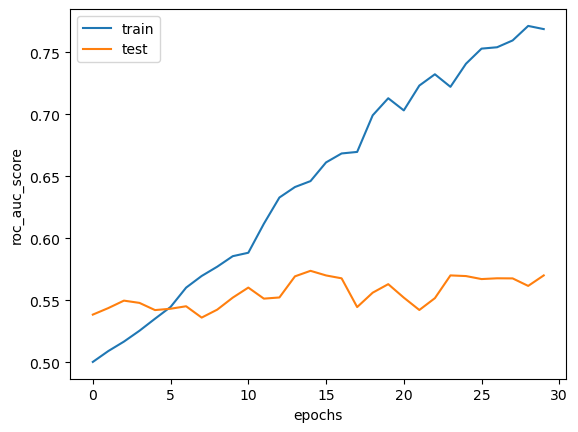

In [94]:
x_values = [i for i in range(len(train_roc_list_fl))]
y_values_1 = train_roc_list_fl
y_values_2 = test_roc_list_fl

plt.plot(x_values, y_values_1)
plt.plot(x_values, y_values_2)

plt.legend(['train', 'test'])

plt.xlabel('epochs')
plt.ylabel('roc_auc_score')

plt.show()